## Week 09
## Deep Q-Learnig

In this session we are going to implement an environment from scratch using **gym** library. Last session we learned about how to interact with environment in gym library and we used a Q-learning and SARSA algorithm to train an agent for frozen lake environment.

So far all the algorithms that we had studied were in the context of classic reinforcement learning.

In this session we will be introducing a new family algorithms which based on both reinforcement learning and machine learning approaches so called **Deep Reinforcement Learning**

The idea about deep reinforcemen learning is to benefit from the complexity and the precision offered by deep learning algorithms.

In high dimensional state space where we have hundred of thousands of state the idea of using classical techniques such as Q-learning or SARSA seems exteremly frustrating.


### flash-back to Q-learning:

Q-learning is a simple yet quite powerful algorithms that gives the agent a cheat sheet to take action. It's a model-free algorithm proposed for control problems.

The formula for udpating Q-table might be altered regarding the eligibility trace **λ**. in the preivous problem we assign λ to 0 so we just get to update one q-value of one state at every timestep.

Q-learning was helping us out stunningly with small-scale environments. out Q-table consist of **number_of_state_space** * **number_of_action_state**. So imagine we are dealing with an environment that has 50,000 states and 500 actions. so the number of cells that we need to keep track of and update would be 25,000,000 cells. in some cases we don't even have a number for state space when the environment is dynamic or non-stationary. here where Deep Q-learning comes to out help.

Deep Q-learning algorithm is ***extended*** version of Q-learning. In deep Q-learning instead of updating a Q-table we use a **Neural Network** called as **Deep Q-Network** to choose action and consequently update it by calculating loss value and backpropagate it through the network.

However, since we do not have a table for every state and action, we **Approximate** Deep-Q(s,a) (Q-values). and usually we take the action with highest Q-value.



---

<img src="https://drive.google.com/uc?id=1AApJb5NcQyhs7hxg4M7bDQ-WVPfbP974"/>



First Let's install the dependencies for today:

In [1]:
!pip install gym numpy torch


## [Cartpole problem](www.gymlibrary.dev/environments/classic_control/cart_pole/)
This environment is part of the Classic Control environments.

This environment corresponds to the version of the cart-pole problem described by [Barto, Sutton, and Anderson in “Neuronlike Adaptive Elements](https://ieeexplore.ieee.org/document/6313077) That Can Solve Difficult Learning Control Problem”. A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The pendulum is placed upright on the cart and the goal is to balance the pole by applying forces in the left and right direction on the cart.



---
| Action Space | Discrete(2)|
| --- | :---: |
| Observation Shape | (4,)|
| Observation High | [4.8, inf, 0.42, inf] |
| Observation Low | [-4.8, -inf, -0.42, -inf] |
| Import | gym.make("CartPole-v1") |



---


<img src="https://drive.google.com/uc?id=1C45DdAmWSVekxgDz6bh7BlqLZkrAM9Hp"/>

In [2]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
import matplotlib.pyplot as plt

loss_list = []

class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, output_dim)
        )

    def forward(self, x):
        return self.network(x)

def get_epsilon(step, eps_start=1, eps_end=0.001, eps_decay=500):
    # print( eps_end + (eps_start - eps_end) * np.exp(-step / eps_decay))
    return eps_end + (eps_start - eps_end) * np.exp(-step / eps_decay)

def select_action(state, q_net, epsilon, action_space):
    if np.random.rand() < epsilon:
        return action_space.sample()
    else:
        with torch.no_grad():
            return torch.argmax(q_net(torch.Tensor(state))).item()

def train(q_net, target_net, memory, optimizer, batch_size, gamma):
    if len(memory) < batch_size:
        return

    batch = random.sample(memory, batch_size)
    states, actions, rewards, next_states, dones = zip(*batch)

    states = torch.tensor(states, dtype=torch.float32)
    actions = torch.tensor(actions, dtype=torch.int64).view(-1, 1)
    rewards = torch.tensor(rewards, dtype=torch.float32).view(-1, 1)
    next_states = torch.tensor(next_states, dtype=torch.float32)
    dones = torch.tensor(dones, dtype=torch.float32).view(-1, 1)

    q_values = torch.gather(q_net(states), dim=1, index=actions)

    with torch.no_grad():
        next_q_values = torch.max(target_net(next_states), dim=1, keepdim=True)[0]
        target_q_values = rewards + (1 - dones) * gamma * next_q_values

    loss = torch.mean((q_values - target_q_values) ** 2)

    loss_list.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # target_net.load_state_dict(q_net.state_dict())

def main():
    env = gym.make("CartPole-v0")
    input_dim = env.observation_space.shape[0]
    output_dim = env.action_space.n

    q_net = DQN(input_dim, output_dim)
    target_net = DQN(input_dim, output_dim)
    target_net.load_state_dict(q_net.state_dict())

    optimizer = optim.Adam(q_net.parameters(), lr=0.00001)
    memory = deque(maxlen=10000)

    num_episodes = 10000
    max_steps = 200
    batch_size = 128
    gamma = 0.99
    update_target_net_freq = 50
    reward_list = []
    for episode in range(num_episodes):
        state, _ = env.reset()
        total_reward = 100
        epsilon = get_epsilon(episode)

        for step in range(max_steps):
            action = select_action(state, q_net, epsilon, env.action_space)
            next_state, reward, done, _, _ = env.step(action)
            if done:
                reward = -100

            memory.append((state, action, reward, next_state, done))

            state = next_state
            total_reward += reward

            if done:
                break

        reward_list.append(total_reward)
        if episode % 1000 == 0:
            print(f"Episode {episode}: Reward = {total_reward}")

        train(q_net, target_net, memory, optimizer, batch_size, gamma)
        # train(q_net, target_net, memory, optimizer, batch_size, gamma)
        if episode % update_target_net_freq == 0:
            target_net.load_state_dict(q_net.state_dict())

    return reward_list


<img src="https://drive.google.com/uc?id=1NZa6T4aXlpBVrofaceT6fWiCXgiGra6j"/>


### Why do we use two separate neural network for Target Q-value and Q-value?

In deep Q-learning, we use two separate neural networks: the Q-network (prediction network) and the target network. This separation aims to stabilize the learning process by reducing correlations between the target and the estimated Q-values, which can lead to oscillations or divergence in the learning.

The Q-network is the one that gets updated frequently during the training process, and its primary purpose is to learn the Q-values, which represent the expected future rewards for each state-action pair. The target network, on the other hand, is updated less frequently and is used to compute the target Q-values.

The target Q-values are calculated using the Bellman equation, which involves the maximum Q-value of the next state. If we use the same network for both prediction and target, the target values would be constantly changing as the network's weights are updated. This can create a moving target problem, making the training process unstable and harder to converge.

By using a separate target network and updating it less frequently, we create a more stable learning environment. The target network effectively acts as a fixed (or slowly changing) target, which allows the Q-network to learn more consistently. This method, known as fixed Q-targets, was introduced in the original Deep Q-Network (DQN) algorithm by DeepMind to address the aforementioned issues and make the learning process more stable and reliable.

using separate neural networks for target and prediction in deep Q-learning helps stabilize the learning process by reducing correlations between target and estimated Q-values, avoiding moving target problems, and ensuring smoother convergence.
### **Note**: that parameters of Target Q-value is update less frequently. and we update it by just passing the weights from Q-value network

<img src="https://drive.google.com/uc?id=1i2a4RedZpFQeEA0D4oScT86153-n9mc3"/>





D:\Innopolis\_my\RLenv\lib\site-packages\gym\envs\registration.py:555: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
D:\Innopolis\_my\RLenv\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
C:\Users\olego\AppData\Local\Temp\ipykernel_10848\1085000303.py:44: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:278.)
  states = torch.tensor(states, dtype=torch.float32)


Episode 0: Reward = 24.0
Episode 1000: Reward = 8.0
Episode 2000: Reward = 14.0
Episode 3000: Reward = 27.0
Episode 4000: Reward = 22.0
Episode 5000: Reward = 14.0
Episode 6000: Reward = 24.0
Episode 7000: Reward = 29.0
Episode 8000: Reward = 17.0
Episode 9000: Reward = 51.0


Text(0, 0.5, 'Score')

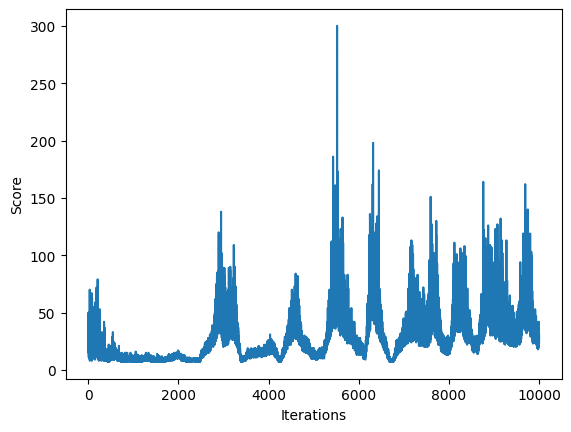

In [3]:
import matplotlib.pyplot as plt
rewards = main()
plt.plot(range(len(rewards)),rewards)
plt.xlabel("Iterations")
plt.ylabel("Score")


# Homework 3
## Double Q-learning

As part of assessing your understanding and skills, this assignment requires you to implement Double Q-learning. You will start by understanding the provided code in the previous section which implements Q-learning for the "CartPole-v0" environment from OpenAI Gym. Your task will be to modify this implementation to adopt the Double Q-learning algorithm.

Q-learning is a model-free reinforcement learning algorithm that seeks to learn a policy dictating the action that an agent should take under a given state. It does this by learning an action-value function that ultimately gives the expected utility of taking a given action in a given state and following a greedy policy thereafter. However, Q-learning can overestimate action values due to the max operation used in the Bellman equation during the update of Q-values.

Double Q-learning addresses this problem by decoupling the selection of the action from the evaluation of that action's value. This is achieved by maintaining two separate Q-networks (Q-network A and Q-network B). Each network's updates are based on the other network's values, which helps in reducing overestimations produced by the max operation.


## Task description
* Modify the Q-learning Implementation:
  *  Create two Q-networks, q_net_a and q_net_b. Both should have the same architecture as the original q_net.
  * During training, alternate between updating q_net_a and q_net_b. For each update:
    * Use one network to determine the best action (action selection) and the other to provide the corresponding Q-value (action evaluation).
  * Ensure that both networks are updated appropriately across training episodes.
* Simulation and Comparison:
  * Run the modified Double Q-learning and the original Q-learning models on the "CartPole-v0" environment.
  * Collect and record the rewards obtained per episode for both models and compare the accumulated reward over time.



## Requirements to be met:

1. Implementation: Successfully modify the provided Q-learning code to implement Double Q-learning.
2. Comparison and Analysis:
 * Plot the rewards per episode for both models using matplotlib to visualize performance differences.
3. Write a one-paragraph summary discussing the observed differences between Q-learning and Double Q-learning in terms of performance and reward stability.


import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
import matplotlib.pyplot as plt

loss_list = []


class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, output_dim)
        )

    def forward(self, x):
        return self.network(x)


def get_epsilon(step, eps_start=1, eps_end=0.001, eps_decay=500):
    # print( eps_end + (eps_start - eps_end) * np.exp(-step / eps_decay))
    return eps_end + (eps_start - eps_end) * np.exp(-step / eps_decay)


def select_action(state, q_net, epsilon, action_space):
    if np.random.rand() < epsilon:
        return action_space.sample()
    else:
        with torch.no_grad():
            return torch.argmax(q_net(torch.Tensor(state))).item()


def train(q_net_a, q_net_b, target_net, memory, optimizer, batch_size, gamma, update_count):
    if len(memory) < batch_size:
        return

    batch = random.sample(memory, batch_size)
    states, actions, rewards, next_states, dones = zip(*batch)

    states = torch.tensor(states, dtype=torch.float32)
    actions = torch.tensor(actions, dtype=torch.int64).view(-1, 1)
    rewards = torch.tensor(rewards, dtype=torch.float32).view(-1, 1)
    next_states = torch.tensor(next_states, dtype=torch.float32)
    dones = torch.tensor(dones, dtype=torch.float32).view(-1, 1)

    if update_count % 2 == 0:
        q_values = torch.gather(q_net_a(states), dim=1, index=actions)
        next_q_values = torch.max(q_net_b(next_states), dim=1, keepdim=True)[0]
    else:
        q_values = torch.gather(q_net_b(states), dim=1, index=actions)
        next_q_values = torch.max(q_net_a(next_states), dim=1, keepdim=True)[0]

    with torch.no_grad():
        target_q_values = rewards + (1 - dones) * gamma * next_q_values

    loss = torch.mean((q_values - target_q_values) ** 2)

    loss_list.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


def double_q_learning():
    env = gym.make("CartPole-v0")
    input_dim = env.observation_space.shape[0]
    output_dim = env.action_space.n

    q_net_a = DQN(input_dim, output_dim)
    q_net_b = DQN(input_dim, output_dim)
    target_net = DQN(input_dim, output_dim)
    target_net.load_state_dict(q_net_a.state_dict())

    optimizer = optim.Adam(q_net_a.parameters(), lr=0.00001)
    memory = deque(maxlen=10000)

    num_episodes = 10000
    max_steps = 200
    batch_size = 128
    gamma = 0.99
    reward_list = []
    update_count = 0
    update_target_net_freq = 50

    for episode in range(num_episodes):
        state, _ = env.reset()
        total_reward = 100
        epsilon = get_epsilon(episode)

        for step in range(max_steps):
            if update_count % 2 == 0:
                action = select_action(state, q_net_a, epsilon, env.action_space)
                q_values = q_net_b(torch.tensor(state, dtype=torch.float32).unsqueeze(0))
            else:
                action = select_action(state, q_net_b, epsilon, env.action_space)
                q_values = q_net_a(torch.tensor(state, dtype=torch.float32).unsqueeze(0))

            next_state, reward, done, _, _ = env.step(action)
            if done:
                reward = -100

            memory.append((state, action, reward, next_state, done))

            state = next_state
            total_reward += reward

            if done:
                break

        reward_list.append(total_reward)
        if episode % 1000 == 0:
            print(f"Episode {episode}: Reward = {total_reward}")

        train(q_net_a, q_net_b, target_net, memory, optimizer, batch_size, gamma, update_count)
        update_count += 1
        if episode % update_target_net_freq == 0:
            target_net.load_state_dict(q_net_a.state_dict())

    return reward_list


def double_q_learning():
    # Initialize environment, networks, optimizer, etc.
    env = gym.make("CartPole-v0")
    input_dim = env.observation_space.shape[0]
    output_dim = env.action_space.n

    # Create two Q-networks
    q_net_a = DQN(input_dim, output_dim)
    q_net_b = DQN(input_dim, output_dim)

    target_net_a = DQN(input_dim, output_dim)
    target_net_b = DQN(input_dim, output_dim)
    target_net_a.load_state_dict(q_net_a.state_dict())
    target_net_b.load_state_dict(q_net_b.state_dict())

    optimizer_a = optim.Adam(q_net_a.parameters(), lr=0.00001)
    optimizer_b = optim.Adam(q_net_b.parameters(), lr=0.00001)

    # Other parameters and variables
    memory = deque(maxlen=10000)
    num_episodes = 10000
    max_steps = 200
    batch_size = 128
    gamma = 0.99
    update_target_net_freq = 50
    reward_list = []

    for episode in range(num_episodes):
        # Initialize episode
        state, _ = env.reset()
        total_reward = 100
        epsilon = get_epsilon(episode)

        for step in range(max_steps):
            # Select action using q_net_a, evaluate using q_net_b
            if episode % 2 == 0:
                action = select_action(state, q_net_a, epsilon, env.action_space)
                q_values = q_net_b(torch.Tensor(state)).detach()
            else:
                action = select_action(state, q_net_b, epsilon, env.action_space)
                q_values = q_net_a(torch.Tensor(state)).detach()

            next_state, reward, done, _, _ = env.step(action)
            if done:
                reward = -100

            memory.append((state, action, reward, next_state, done))

            state = next_state
            total_reward += reward

            if done:
                break

        reward_list.append(total_reward)
        if episode % 1000 == 0:
            print(f"Episode {episode}: Reward = {total_reward}")

        # Update q_net_a or q_net_b based on episode number
        if episode % 2 == 0:
            train(q_net_a, target_net_a, memory, optimizer_a, batch_size, gamma)
        else:
            train(q_net_b, target_net_b, memory, optimizer_b, batch_size, gamma)

        # Update target networks
        if episode % update_target_net_freq == 0:
            target_net_a.load_state_dict(q_net_a.state_dict())
            target_net_b.load_state_dict(q_net_b.state_dict())

    return reward_list


In [17]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
import matplotlib.pyplot as plt

loss_list = []

class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, output_dim)
        )

    def forward(self, x):
        return self.network(x)

def get_epsilon(step, eps_start=1, eps_end=0.001, eps_decay=500):
    return eps_end + (eps_start - eps_end) * np.exp(-step / eps_decay)

def select_action(state, q_net, epsilon, action_space):
    if np.random.rand() < epsilon:
        return action_space.sample()
    else:
        with torch.no_grad():
            return torch.argmax(q_net(torch.Tensor(state))).item()

def train(q_net_a, q_net_b, target_net, memory, optimizer, batch_size, gamma):
    if len(memory) < batch_size:
        return

    batch = random.sample(memory, batch_size)
    states, actions, rewards, next_states, dones = zip(*batch)

    states = torch.tensor(states, dtype=torch.float32)
    actions = torch.tensor(actions, dtype=torch.int64).view(-1, 1)
    rewards = torch.tensor(rewards, dtype=torch.float32).view(-1, 1)
    next_states = torch.tensor(next_states, dtype=torch.float32)
    dones = torch.tensor(dones, dtype=torch.float32).view(-1, 1)

    q_values_a = torch.gather(q_net_a(states), dim=1, index=actions)
    q_values_b = torch.gather(q_net_b(states), dim=1, index=actions)

    with torch.no_grad():
        next_q_values = torch.max(target_net(next_states), dim=1, keepdim=True)[0]
        target_q_values = rewards + (1 - dones) * gamma * next_q_values

    loss_a = torch.mean((q_values_a - target_q_values) ** 2)
    loss_b = torch.mean((q_values_b - target_q_values) ** 2)
    loss = loss_a + loss_b

    loss_list.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

def double_q_learning():
    env = gym.make("CartPole-v0")
    input_dim = env.observation_space.shape[0]
    output_dim = env.action_space.n

    q_net_a = DQN(input_dim, output_dim)
    q_net_b = DQN(input_dim, output_dim)
    target_net = DQN(input_dim, output_dim)
    target_net.load_state_dict(q_net_a.state_dict())

    optimizer = optim.Adam(q_net_a.parameters(), lr=0.00001)
    memory = deque(maxlen=10000)

    num_episodes = 10000
    max_steps = 200
    batch_size = 128
    gamma = 0.99
    update_target_net_freq = 50
    reward_list = []

    for episode in range(num_episodes):
        state, _ = env.reset()
        total_reward = 100
        epsilon = get_epsilon(episode)

        for step in range(max_steps):
            action = select_action(state, q_net_a, epsilon, env.action_space)
            next_state, reward, done, _, _ = env.step(action)
            if done:
                reward = -100

            memory.append((state, action, reward, next_state, done))

            state = next_state
            total_reward += reward

            if done:
                break

        reward_list.append(total_reward)
        if episode % 1000 == 0:
            print(f"Episode {episode}: Reward = {total_reward}")

        train(q_net_a, q_net_b, target_net, memory, optimizer, batch_size, gamma)

        if episode % update_target_net_freq == 0:
            target_net.load_state_dict(q_net_a.state_dict())

    return reward_list

Episode 0: Reward = 21.0
Episode 1000: Reward = 17.0
Episode 2000: Reward = 36.0
Episode 3000: Reward = 19.0
Episode 4000: Reward = 39.0
Episode 5000: Reward = 24.0
Episode 6000: Reward = 34.0
Episode 7000: Reward = 36.0
Episode 8000: Reward = 71.0
Episode 9000: Reward = 54.0


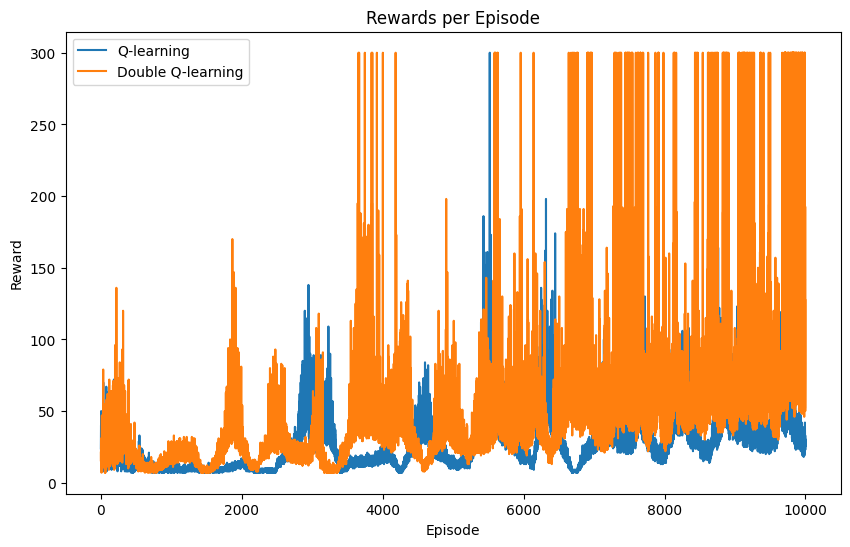

In [18]:
import gym
import matplotlib.pyplot as plt

# Ваш модифицированный код для Double Q-learning и оригинальный Q-learning здесь

def plot_rewards(reward_lists, labels):
    plt.figure(figsize=(10, 6))
    for rewards, label in zip(reward_lists, labels):
        plt.plot(rewards, label=label)
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Rewards per Episode')
    plt.legend()
    plt.show()

if __name__ == "__main__":
    # Запуск обеих моделей
    rewards_double_q_learning = double_q_learning()  # Замените main() на вашу функцию для Double Q-learning
    rewards_q_learning = rewards  # Здесь должен быть ваш код для оригинального Q-learning

    # Сравнение аккумулированных наград
    plot_rewards([rewards_q_learning, rewards_double_q_learning], ['Q-learning', 'Double Q-learning'])


# Summary

The observed differences between Q-learning and Double Q-learning in terms of performance and reward stability indicate that Double Q-learning tends to provide more stable and reliable rewards over time compared to traditional Q-learning. While Q-learning may exhibit higher variance in reward accumulation due to its reliance on single Q-values for both action selection and evaluation, Double Q-learning mitigates this issue by decoupling action selection and evaluation using two separate Q-networks. This decoupling allows Double Q-learning to provide more accurate estimates of action values, resulting in smoother learning curves and less fluctuation in rewards throughout the training process. Consequently, Double Q-learning demonstrates improved performance and reward stability, making it a more robust choice for reinforcement learning tasks such as the "CartPole-v0" environment.